# Comparison of Victron Data to Clearsky Model

## Imports

In [104]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from userdefinedmodels import *
import solarpanels

## Setup Location

In [105]:
# latitude, longitude, name, altitude, timezone
dredgers_key = (24.5833546, -81.7670295, 'Dredgers Key', 1, 'Etc/GMT+5')
latitude, longitude, name, altitude, timezone = dredgers_key

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

## Create Dataframe from Victron Data



In [106]:
# create dataframe for pv data from sigsby_sunset_2024-2-7.csv
pv_data = pd.read_csv('dredgerskey_sunset_2024-2-7.csv')

# convert to datetime
pv_data['datetime'] = pd.to_datetime(pv_data['timestamp (-05:00)'])

# set index to datetime
pv_data = pv_data.set_index('datetime')

# localize to location timezone
pv_data = pv_data.tz_localize(location.tz)

# fill Nan with next value
pv_data = pv_data.bfill()

# get first and last datetime values
start = pv_data.index[0]
end = pv_data.index[-1]

## Setup Clearsky Data

In [107]:
times = pd.date_range(start, end, freq='1s', tz=location.tz)
weather = location.get_clearsky(times)

# add temperature data (measured data was 19.8C over this period)
#weather['temp_air'] = 19.8

In [108]:
# Get the date
date = pd.Timestamp(times[0].date()).tz_localize(location.tz)

# Create a DatetimeIndex with the single date
times_single_day = pd.DatetimeIndex([date])

# Get sunrise, sunset, and transit times for the date
result = location.get_sun_rise_set_transit(times_single_day)

# Get sunrise, sunset, and transit times from the DataFrame
sunrise = result['sunrise'].iloc[0]
sunset = result['sunset'].iloc[0]
transit = result['transit'].iloc[0]

# Setup the System

In [109]:
# Module Parameters
rich_solar_24V_params = solarpanels.get_rich_solar_MEGA200Max_24V()

# Temperature Parameters
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Inverter Parameters
r_batt_wire = getWireResistance('8AWG', 6) # based on van build records
r_pv_wire = getWireResistance('12AWG', 30) # based on van build records
mppt_eff = 0.98

mppt_parameters = {
    'v_batt': 26.6,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': mppt_eff
}

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_24V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=2,
    modules_per_string=2,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )



# Run the Model

In [110]:
mc.run_model(weather)

print(mc.results.weather.head())

                                  ghi        dhi         dni  wind_speed  \
2024-02-07 16:00:00-05:00  416.359203  89.820301  712.558881           0   
2024-02-07 16:00:01-05:00  416.302208  89.814679  712.522268           0   
2024-02-07 16:00:02-05:00  416.245210  89.809056  712.485646           0   
2024-02-07 16:00:03-05:00  416.188209  89.803432  712.449017           0   
2024-02-07 16:00:04-05:00  416.131203  89.797807  712.412378           0   

                           temp_air  
2024-02-07 16:00:00-05:00        20  
2024-02-07 16:00:01-05:00        20  
2024-02-07 16:00:02-05:00        20  
2024-02-07 16:00:03-05:00        20  
2024-02-07 16:00:04-05:00        20  


# Compare Data to Model

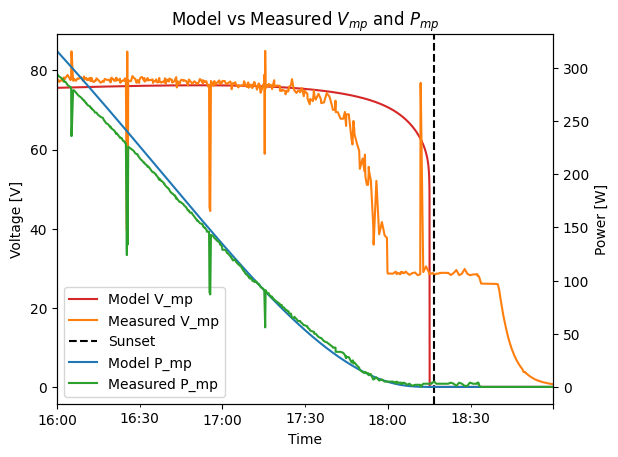

In [111]:
fig, ax1 = plt.subplots()

# Plotting voltage - Using pandas plot method with ax parameter
(mc.results.dc['v_mp'] - mc.results.dc_ohmic_losses['v_pv_wire_drop']).plot(ax=ax1, color='tab:red', label='Model V_mp')
pv_data['V_mp'].plot(ax=ax1, color='tab:orange', label='Measured V_mp')
#mc.results.dc['v_oc'].plot(ax=ax1, color='tab:purple', label='Model V_oc')

# Setting up the primary y-axis (ax1) for voltage
ax1.set_ylabel('Voltage [V]')
ax1.tick_params(axis='y')

# Drawing the sunset line and setting labels
ax1.axvline(x=sunset, color='k', linestyle='--', label='Sunset')
ax1.set_xlabel('Time')

# Formatting the x-axis to display time in HH:MM format
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels to improve readability

# Creating the secondary y-axis (ax2) for power
ax2 = ax1.twinx()

# Plotting power - Using pandas plot method with ax parameter
mc.results.ac.plot(ax=ax2, color='tab:blue', label='Model P_mp', legend=False)
pv_data['P_mp'].plot(ax=ax2, color='tab:green', label='Measured P_mp', legend=False)
#mc.results.effective_irradiance.plot(ax=ax2, color='tab:gray', label='GHI', legend=False)

# Setting up the secondary y-axis (ax2) for power
ax2.set_ylabel('Power [W]')
ax2.tick_params(axis='y')

# Handling legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower left')

# Setting the title
plt.title('Model vs Measured $V_{mp}$ and $P_{mp}$')

# Show the combined plot
plt.show()

